In [36]:
import yfinance as yf
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import numpy as np
import pandas as pd
import copy

stocks = pd.read_pickle('../Datas/tickers21-23')
stocks.head()

,AAPL,BABA,GIS,LLY,XOM
Date,,,,,
2021-03-16,124.076462,226.929993,55.907032,185.688400,54.054691
2021-03-17,123.276100,233.339996,55.916451,181.632233,54.292450
2021-03-18,119.096413,236.429993,56.396618,178.908691,51.951389
2021-03-19,118.562836,239.789993,56.556671,179.258850,51.658768
2021-03-22,121.922401,237.119995,57.855968,180.766541,51.128361


### Mean-Variance Optimal Portfolio
- Need Expected returns for each stocks
- Need the covariance matrix of all stocks returns
- Minimizing the portfolio varianc
- Efficient frontier -> point that maximize the Sharpe ratio


### Returns / Mean_historical_Expected_returns

AAPL    0.101872
BABA   -0.397410
GIS     0.195924
LLY     0.324140
XOM     0.406766
dtype: float64

<Axes: xlabel='Date'>

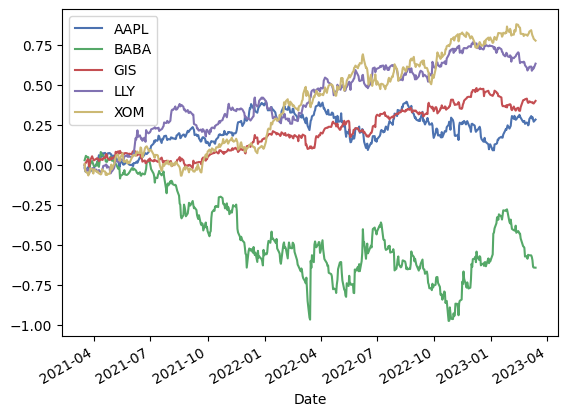

In [37]:
stocks_returns = stocks.pct_change()[1:]
stocks_returns.head()
exp_ret = expected_returns.mean_historical_return(stocks)
display(exp_ret)
stocks.pct_change()[1:].cumsum().plot()

### Variance / Covariance Matrix

,AAPL,BABA,GIS,LLY,XOM
AAPL,0.090531,0.056532,0.009710,0.023216,0.022187
BABA,0.056532,0.380480,-0.007615,0.005406,0.023060
GIS,0.009710,-0.007615,0.043683,0.014627,0.003365
LLY,0.023216,0.005406,0.014627,0.075242,0.010861
XOM,0.022187,0.023060,0.003365,0.010861,0.097809


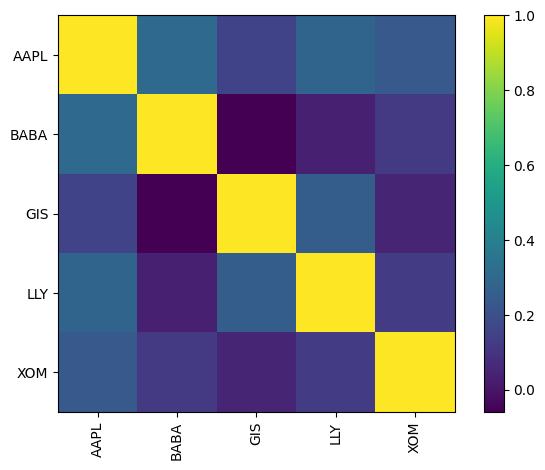

In [38]:
# variance / covariance matrix
cov_matrix2 = risk_models.sample_cov(stocks)
display(cov_matrix2)
plotting.plot_covariance(cov_matrix2, plot_correlation=True);


### Efficient Frontier for maximizing sharpe ratio

In [39]:
from pypfopt import objective_functions

ef = EfficientFrontier(exp_ret, cov_matrix2)
# optimizing to have less negligible weights 
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
w = ef.max_sharpe()
print(ef.clean_weights())


OrderedDict([('AAPL', 0.0), ('BABA', 0.0), ('GIS', 0.23218), ('LLY', 0.34784), ('XOM', 0.41998)])


c:\Users\feldm\Documents\GitHub\portfolio_forecasting\myenv\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:262: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


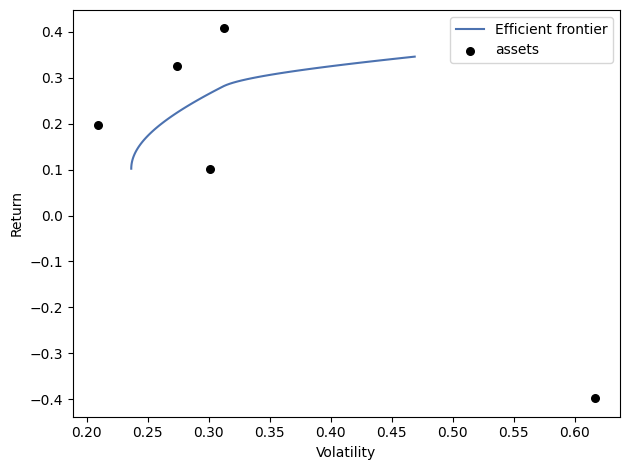

In [42]:
ef = EfficientFrontier(exp_ret, cov_matrix2, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

In [46]:

ef = EfficientFrontier(exp_ret, cov_matrix2, weight_bounds=(None, None))

plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
ef.portfolio_performance(verbose=True)


Expected annual return: 32.9%
Annual volatility: 18.7%
Sharpe Ratio: 1.65


(0.3290722783476237, 0.18682305843694905, 1.6543583053048698)